<a href="https://colab.research.google.com/github/YujiK-github/kaggle_LECR/blob/main/3rd_stage_model/stacking_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pandas._libs.tslibs.period import freq_to_dtype_code
# ================================================================
#  Library
# ================================================================
import os
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error as mse

import torch

import lightgbm as lgb

import optuna
from optuna import logging
logging.set_verbosity(logging.WARNING)

# ================================================================
#  Utils
# ================================================================
def seed_everything(cfg):
    """set seed"""
    random.seed(cfg.seed)
    os.environ['PYTHONHASHSEED'] = str(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    torch.cuda.manual_seed(cfg.seed)
    torch.backends.cudnn.deterministic = True


def fbeta_score(y_true_ids: pd.Series, y_pred_ids: pd.Series, beta=2, eps=1e-15):
    """
    Args:
        y_true_ids: true labels
        y_pred_ids: predictions

    It is assumed that the above two are in the same topic order.
    """
    true_ids = y_true_ids.str.split()
    pred_ids = y_pred_ids.str.split()
    score_list = []
    for true, pred in zip(true_ids, pred_ids):
        TP = (set(true) & set(pred))
        try:
            precision = len(TP) / len(pred)
            recall = len(TP) / len(true)
            f2 = (1+beta**2) * (precision*recall) / ((beta**2)*precision+recall+eps)
        except:
            f2 = 0
        score_list.append(f2)

    try:
        score = sum(score_list) / len(score_list)
    except:
        score = 0
    return score


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def get_f2_score(predictions, valid_folds, TOP, apply_sigmoid):
    if apply_sigmoid:
        valid_folds["sigmoid"] = sigmoid(predictions)
    else:
        valid_folds["sigmoid"] = predictions
    best_score = -np.inf
    best_thrshold = 0
    df_corr = pd.read_csv("/content/drive/MyDrive/KAGGLE-LECR/correlations.csv")

    top_sigmoids = valid_folds.groupby('topic_id').apply(lambda x: x.sort_values(by='sigmoid', ascending=False).head(TOP)).reset_index(drop=True)
    top_sigmoids = pd.DataFrame(top_sigmoids.groupby("topic_id")["predictions"].agg(list)).reset_index()
    top_sigmoids["predictions"] = top_sigmoids["predictions"].apply(lambda x: " ".join(x))
    count = 0
    start = freq = 0.001
    with tqdm(np.arange(start, 0.5, freq), desc="Search best threshold") as pbar:
        for thre in pbar:
            if count == 10:
                break
            valid_folds["pred"] = np.where(valid_folds["sigmoid"] > thre, 1, 0)        
            pred_1 = valid_folds[valid_folds["pred"] == 1].reset_index(drop=True)        

            topic_true = pd.DataFrame(pred_1.groupby("topic_id")["predictions"].agg(list)).reset_index()
            topic_true["predictions"] = topic_true["predictions"].apply(lambda x: " ".join(x))

            # predictionsがないものも考慮する
            least_df = top_sigmoids[~top_sigmoids["topic_id"].isin(topic_true["topic_id"].values)].reset_index(drop=True)
            topic_true = pd.concat([topic_true, least_df], ignore_index=True)
            topic_true = pd.merge(topic_true, df_corr, on="topic_id", how="left")
            score = fbeta_score(topic_true["content_ids"], topic_true["predictions"])        
            count += 1
            if score > best_score:
                count = 0
                best_score = score
                best_threshold = thre
                pbar.set_postfix(OrderedDict(best_score=score, best_threshold = thre))
    return best_score, best_threshold


def get_max_score(y_true_ids, y_pred_ids, beta=2, eps=1e-15):
    """
    precision -> 1
    recall -> No change
    """
    true_ids = y_true_ids.str.split()
    pred_ids = y_pred_ids.str.split()
    score_list = []
    for true, pred in zip(tqdm(true_ids), pred_ids):
        TP = (set(true) & set(pred))
        #precision = len(TP) / len(pred) 
        precision = 1
        recall = len(TP) / len(true)     
        f2 = (1+beta**2) * (precision*recall) / ((beta**2)*precision+recall+eps)
        score_list.append(f2)
    score = sum(score_list) / len(score_list)
    return score


def get_score(y_true_ids, y_pred_ids, beta=2, eps=1e-15):
    true_ids = y_true_ids.str.split()
    pred_ids = y_pred_ids.str.split()
    score_list = []
    for true, pred in zip(true_ids, pred_ids):
        TP = (set(true) & set(pred))
        try:
            precision = len(TP) / len(pred) 
            #precision = 1
            recall = len(TP) / len(true)     
            f2 = (1+beta**2) * (precision*recall) / ((beta**2)*precision+recall+eps)
        except:
            f2 = 0
        score_list.append(f2)
    score = sum(score_list) / len(score_list)
    return score


def get_pos_score(y_true_ids, y_pred_ids):
    """
    calculate recall
    ref: https://www.kaggle.com/code/ragnar123/lecr-unsupervised-train-set-public
    """
    y_true_ids = y_true_ids.str.split()
    y_pred_ids = y_pred_ids.str.split()
    score_list = []
    for true, pred in zip(y_true_ids, y_pred_ids):
        score_list.append(np.array([len(set(true) & set(pred)) / len(true)]))
    return round(np.mean(score_list), 5)  

In [ ]:
# ==================================================
#  args
# ==================================================
class CFG:
    data_dir = "/content/drive/MyDrive/KAGGLE-LECR/last_data/"
    competition_dir = "/content/drive/MyDrive/KAGGLE-LECR/last_data/"
    seed = 42
    output_dir = data_dir+"3rd/"
    target_cols = ["target"]
    n_trials = 20
    fold = [0, 1, 2, 3, 4]

# ==================================================
#  DirectlySetting
# ==================================================
if not os.path.exists(CFG.output_dir):
    os.makedirs(CFG.output_dir)

seed_everything(CFG)

In [ ]:
# ==================================================
#  DataLoading
# ==================================================
df = pd.read_csv(CFG.data_dir+"3rd/df_ver2.csv")

df_1 = pd.read_csv(CFG.data_dir+"2nd/exp004/fold0/oof_df_fold0_epoch3.csv")
df_2 = pd.read_csv(CFG.data_dir+"2nd/exp006/fold0/oof_df_fold0_epoch3.csv")
df_3 = pd.read_csv(CFG.data_dir+"2nd/exp007/fold0/oof_df_fold0_epoch3.csv")
df_4 = pd.read_csv(CFG.data_dir+"2nd/exp008/fold0/oof_df_fold0_epoch3.csv")

df = pd.merge(df, 
              df_1[["topic_id", "predictions", "valid_pred"]].rename(columns={"valid_pred":"valid_pred_ver0"}),
              on=["topic_id", "predictions"], how="left")

df = pd.merge(df, 
              df_2[["topic_id", "predictions", "valid_pred"]].rename(columns={"valid_pred":"valid_pred_ver1"}),
              on=["topic_id", "predictions"], how="left")

df = pd.merge(df,
              df_3[["topic_id", "predictions", "valid_pred"]].rename(columns={"valid_pred":"valid_pred_ver2"}),
              on=["topic_id", "predictions"], how="left")

df = pd.merge(df,
              df_4[["topic_id", "predictions", "valid_pred"]].rename(columns={"valid_pred":"valid_pred_ver3"}),
              on=["topic_id", "predictions"], how="left")

In [ ]:
for i in range(4):
    sub_df = df.groupby("topic_id")[f"valid_pred_ver{i}"].agg(["mean", "min", "max", "std"]).rename(columns=lambda x: f"{x}_per_topic_ver{i}").reset_index()
    sub_df[f"range_per_topic_ver{i}"] = sub_df[f"max_per_topic_ver{i}"] - sub_df[f"min_per_topic_ver{i}"]
    df = pd.merge(df, sub_df, on="topic_id", how="left")

In [ ]:
df

,topic_id,predictions,target,topic_language,topic_channel,topic_category,topic_level,score,content_language,content_kind,...,mean_per_topic_ver2,min_per_topic_ver2,max_per_topic_ver2,std_per_topic_ver2,range_per_topic_ver2,mean_per_topic_ver3,min_per_topic_ver3,max_per_topic_ver3,std_per_topic_ver3,range_per_topic_ver3
0,t_0012a45fa09c,c_dde078b8ea7a,1,en,2ee29d,aligned,4,0.743472,en,exercise,...,-11.283515,-12.848917,10.771988,3.303705,23.620905,-9.470173,-10.466448,8.593512,2.657373,19.059960
1,t_0012a45fa09c,c_139907ad9cf0,0,en,2ee29d,aligned,4,0.669632,en,video,...,-11.283515,-12.848917,10.771988,3.303705,23.620905,-9.470173,-10.466448,8.593512,2.657373,19.059960
2,t_0012a45fa09c,c_05a5aed8ccec,0,en,2ee29d,aligned,4,0.613423,en,document,...,-11.283515,-12.848917,10.771988,3.303705,23.620905,-9.470173,-10.466448,8.593512,2.657373,19.059960
3,t_0012a45fa09c,c_26fd56fd6382,0,en,2ee29d,aligned,4,0.597120,en,video,...,-11.283515,-12.848917,10.771988,3.303705,23.620905,-9.470173,-10.466448,8.593512,2.657373,19.059960
4,t_0012a45fa09c,c_92153d6a566d,0,en,2ee29d,aligned,4,0.595151,en,exercise,...,-11.283515,-12.848917,10.771988,3.303705,23.620905,-9.470173,-10.466448,8.593512,2.657373,19.059960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359495,t_fff9e5407d13,c_026db653a269,1,es,71fd51,supplemental,2,0.551677,es,html5,...,-9.033782,-12.566412,11.782205,6.999060,24.348617,-7.463059,-10.413857,9.236372,6.115587,19.650229
359496,t_fff9e5407d13,c_b894de7e8725,0,es,71fd51,supplemental,2,0.551287,pt,html5,...,-9.033782,-12.566412,11.782205,6.999060,24.348617,-7.463059,-10.413857,9.236372,6.115587,19.650229
359497,t_fff9e5407d13,c_f7e15fcee474,0,es,71fd51,supplemental,2,0.550654,pt,html5,...,-9.033782,-12.566412,11.782205,6.999060,24.348617,-7.463059,-10.413857,9.236372,6.115587,19.650229
359498,t_fff9e5407d13,c_4fee67386c4a,0,es,71fd51,supplemental,2,0.550607,es,html5,...,-9.033782,-12.566412,11.782205,6.999060,24.348617,-7.463059,-10.413857,9.236372,6.115587,19.650229


In [ ]:
df.columns

Index(['topic_id', 'predictions', 'target', 'topic_language', 'topic_channel',
       'topic_category', 'topic_level', 'score', 'content_language',
       'content_kind', 'fold', 'valid_pred_ver0', 'valid_pred_ver1',
       'valid_pred_ver2', 'valid_pred_ver3', 'mean_per_topic_ver0',
       'min_per_topic_ver0', 'max_per_topic_ver0', 'std_per_topic_ver0',
       'range_per_topic_ver0', 'mean_per_topic_ver1', 'min_per_topic_ver1',
       'max_per_topic_ver1', 'std_per_topic_ver1', 'range_per_topic_ver1',
       'mean_per_topic_ver2', 'min_per_topic_ver2', 'max_per_topic_ver2',
       'std_per_topic_ver2', 'range_per_topic_ver2', 'mean_per_topic_ver3',
       'min_per_topic_ver3', 'max_per_topic_ver3', 'std_per_topic_ver3',
       'range_per_topic_ver3'],
      dtype='object')

In [ ]:
df["topic_category_"] = df["topic_category"].map({"aligned":0, "supplemental":1})
df["content_kind_"] = df["content_kind"].map({"document":0, 
                                              "video":1,
                                              "exercise":2,
                                              "audio":3,
                                              "html5":4})

In [ ]:
df["topic_language_is_en"] = np.where(df["topic_language"] == "en", 1, 0)
df["topic_language_is_es"] = np.where(df["topic_language"] == "es", 1, 0)

df["content_language_is_en"] = np.where(df["content_language"] == "en", 1, 0)
df["content_language_is_es"] = np.where(df["content_language"] == "es", 1, 0)

df["language_is_the_same"] = np.where(df["topic_language"] == df["content_language"], 1, 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359500 entries, 0 to 359499
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   topic_id                359500 non-null  object 
 1   predictions             359500 non-null  object 
 2   target                  359500 non-null  int64  
 3   topic_language          359500 non-null  object 
 4   topic_channel           359500 non-null  object 
 5   topic_category          359500 non-null  object 
 6   topic_level             359500 non-null  int64  
 7   score                   359500 non-null  float64
 8   content_language        359500 non-null  object 
 9   content_kind            359500 non-null  object 
 10  fold                    359500 non-null  float64
 11  valid_pred_ver0         359500 non-null  float64
 12  valid_pred_ver1         359500 non-null  float64
 13  valid_pred_ver2         359500 non-null  float64
 14  valid_pred_ver3     

In [ ]:
df

,topic_id,predictions,target,topic_language,topic_channel,topic_category,topic_level,score,content_language,content_kind,...,max_per_topic_ver3,std_per_topic_ver3,range_per_topic_ver3,topic_category_,content_kind_,topic_language_is_en,topic_language_is_es,content_language_is_en,content_language_is_es,language_is_the_same
0,t_0012a45fa09c,c_dde078b8ea7a,1,en,2ee29d,aligned,4,0.743472,en,exercise,...,8.593512,2.657373,19.059960,0,2,1,0,1,0,1
1,t_0012a45fa09c,c_139907ad9cf0,0,en,2ee29d,aligned,4,0.669632,en,video,...,8.593512,2.657373,19.059960,0,1,1,0,1,0,1
2,t_0012a45fa09c,c_05a5aed8ccec,0,en,2ee29d,aligned,4,0.613423,en,document,...,8.593512,2.657373,19.059960,0,0,1,0,1,0,1
3,t_0012a45fa09c,c_26fd56fd6382,0,en,2ee29d,aligned,4,0.597120,en,video,...,8.593512,2.657373,19.059960,0,1,1,0,1,0,1
4,t_0012a45fa09c,c_92153d6a566d,0,en,2ee29d,aligned,4,0.595151,en,exercise,...,8.593512,2.657373,19.059960,0,2,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359495,t_fff9e5407d13,c_026db653a269,1,es,71fd51,supplemental,2,0.551677,es,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,1,1
359496,t_fff9e5407d13,c_b894de7e8725,0,es,71fd51,supplemental,2,0.551287,pt,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,0,0
359497,t_fff9e5407d13,c_f7e15fcee474,0,es,71fd51,supplemental,2,0.550654,pt,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,0,0
359498,t_fff9e5407d13,c_4fee67386c4a,0,es,71fd51,supplemental,2,0.550607,es,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,1,1


In [ ]:
df.columns

Index(['topic_id', 'predictions', 'target', 'topic_language', 'topic_channel',
       'topic_category', 'topic_level', 'score', 'content_language',
       'content_kind', 'fold', 'valid_pred_ver0', 'valid_pred_ver1',
       'valid_pred_ver2', 'valid_pred_ver3', 'mean_per_topic_ver0',
       'min_per_topic_ver0', 'max_per_topic_ver0', 'std_per_topic_ver0',
       'range_per_topic_ver0', 'mean_per_topic_ver1', 'min_per_topic_ver1',
       'max_per_topic_ver1', 'std_per_topic_ver1', 'range_per_topic_ver1',
       'mean_per_topic_ver2', 'min_per_topic_ver2', 'max_per_topic_ver2',
       'std_per_topic_ver2', 'range_per_topic_ver2', 'mean_per_topic_ver3',
       'min_per_topic_ver3', 'max_per_topic_ver3', 'std_per_topic_ver3',
       'range_per_topic_ver3', 'topic_category_', 'content_kind_',
       'topic_language_is_en', 'topic_language_is_es',
       'content_language_is_en', 'content_language_is_es',
       'language_is_the_same'],
      dtype='object')

In [ ]:
# ==================================================
#  Feature Engineering
# ==================================================
CFG.use_features = ['topic_level', 'score', 'valid_pred_ver0', 'valid_pred_ver1',
       'valid_pred_ver2', 'valid_pred_ver3', 'mean_per_topic_ver0',
       'min_per_topic_ver0', 'max_per_topic_ver0', 'std_per_topic_ver0',
       'range_per_topic_ver0', 'mean_per_topic_ver1', 'min_per_topic_ver1',
       'max_per_topic_ver1', 'std_per_topic_ver1', 'range_per_topic_ver1',
       'mean_per_topic_ver2', 'min_per_topic_ver2', 'max_per_topic_ver2',
       'std_per_topic_ver2', 'range_per_topic_ver2', 'mean_per_topic_ver3',
       'min_per_topic_ver3', 'max_per_topic_ver3', 'std_per_topic_ver3',
       'range_per_topic_ver3', 'topic_category_', 'content_kind_',
       'topic_language_is_en', 'topic_language_is_es',
       'content_language_is_en', 'content_language_is_es',
       'language_is_the_same']
CFG.cat_features = ["topic_category_", "content_kind_",  'topic_language_is_en', 'topic_language_is_es',
       'content_language_is_en', 'content_language_is_es', 'topic_level',
       'language_is_the_same']

In [ ]:
# ==================================================
#  Model
# ==================================================
class CustomModel:
    """
    
    stacking model
    ref) https://www.kaggle.com/code/horsek/fb-eff-157a-stage3-train
    
    """
    def __init__(self, cfg, param: dict, fold: list):
        self.param = param
        self.cfg = cfg
        self.fold = fold
        
    def get_score(self, y_true: np.array, y_pred: np.array) -> int:
        score = log_loss(y_true, y_pred)
        return score
    
    def lgb_train(self, param: dict, df_train: pd.DataFrame, df_valid: pd.DataFrame()):
        """foldごとのtraining"""
        feature_importance_df = pd.DataFrame()
        feature_importance_df["feature"] = self.cfg.use_features
        
        if self.cfg.cat_features != []:
            trn_data = lgb.Dataset(df_train[self.cfg.use_features], 
                                label=df_train["target"].values, 
                                categorical_feature=self.cfg.cat_features)
        
            val_data = lgb.Dataset(df_valid[self.cfg.use_features], 
                                label=df_valid["target"].values, 
                                categorical_feature=self.cfg.cat_features)
        else:
            trn_data = lgb.Dataset(df_train[self.cfg.use_features], 
                                label=df_train["target"].values)
        
            val_data = lgb.Dataset(df_valid[self.cfg.use_features], 
                                label=df_valid["target"].values)
        
        clf = lgb.train(param,
                        trn_data,
                        num_boost_round=10000,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=-1,
                        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
                        )
            
        pred = clf.predict(df_valid[self.cfg.use_features], 
                           num_iteraion=clf.best_iteration)
        df_valid["pred"] = pred
        
        feature_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        return clf, feature_importance_df, df_valid


    def train(self, param: dict, df: pd.DataFrame):
        """train_loop"""
        oof_df = pd.DataFrame()
        self.feature_importance_df = pd.DataFrame()
        for fold in (self.fold):
            # data split
            df_train = df[df["fold"] != fold].reset_index(drop=True)
            df_valid = df[df["fold"] == fold].reset_index(drop=True)
            
            # train
            clf, fold_importance_df, _oof_df = self.lgb_train(param, df_train, df_valid)

            # save
            model_path = self.cfg.output_dir + f"lgb_fold{fold}_model.pkl"
            with open(model_path, 'wb') as fout:
                pickle.dump(clf, fout)
                
            # get pred
            oof_df = pd.concat([oof_df, _oof_df], ignore_index=True)
                
            # feature importance
            fold_importance_df['fold'] = fold
            self.feature_importance_df = pd.concat([self.feature_importance_df, fold_importance_df], axis=0)
            
            # fold score
            #score = self.get_rmse(df_valid["target"].values, df_valid["pred"].values)
            # print(f"fold{fold} score: ", score)
            
        score = self.get_score(oof_df["target"].values, oof_df["pred"].values)
        return score, oof_df, self.feature_importance_df


    def optimize_param(self, df: pd.DataFrame()):
        base_param = self.param
        def objective(trial):
            param = base_param.copy()
            study_param = {
                'subsample': trial.suggest_loguniform('subsample', 0.8, 1.0),
                'subsample_freq': trial.suggest_int('subsample_freq', 1, 4),
                'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-6, 1.0),
                'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-6, 1.0),
                'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-6, 1.0),
            }
            param.update(study_param)
            score, _, _ = self.train(param, df)
            return score
        study = optuna.create_study(direction="minimize",
                                    sampler=optuna.samplers.RandomSampler(seed=self.cfg.seed),
                                    )
        study.optimize(objective, 
                       n_trials=self.cfg.n_trials, 
                       show_progress_bar=True)
        trial = study.best_trial
        best_params = trial.params.items()
        best_param_dict = dict(list(best_params))
        param = base_param.copy()
        param.update(best_param_dict)
        self.param = param
        print(param)
        return param
    
    def lgb_predict(self, clf, df: pd.DataFrame):
        prediction = clf.predict(df[self.use_features].values, num_iteraion=clf.best_iteration)
        return prediction
    
    def predict(self, df: pd.DataFrame):
        predictions = []
        for fold in self.fold:
            model_path = self.cfg.output_dir + f"lgb_fold{fold}_model.pkl"
            with open(model_path, 'rb') as fin:
                clf = pickle.load(fin)
            prediction = self.lgb_predict(clf, df)
            predictions.append(prediction)
        predictions = np.mean(predictions, axis=0)
        df["pred"] = predictions
        return df

    def show_feature_importance(self, figsize=(4, 6)):
        best_features = (self.feature_importance_df[["feature", "importance"]]
                         .groupby("feature", as_index=False).mean().sort_values(by="importance", ascending=False).head(50))
        plt.figure(figsize=figsize)
        sns.barplot(x="importance", y="feature", data=best_features)
        plt.title('Features importance (averaged/folds)')
        plt.tight_layout()

In [ ]:
# ==================================================
#  train
# ==================================================

params = {
    'objective': 'binary', 
    'random_state':CFG.seed,
    'metric': 'cross_entropy',  
    'verbose': -1,
}

model = CustomModel(CFG, params, CFG.fold)

In [ ]:
params = model.optimize_param(df)

  0%|          | 0/20 [00:00<?, ?it/s]

{'objective': 'binary', 'random_state': 42, 'metric': 'cross_entropy', 'verbose': -1, 'subsample': 0.9932359854528829, 'subsample_freq': 4, 'reg_alpha': 0.43350453927751326, 'reg_lambda': 0.2338643925620872, 'min_split_gain': 0.003867228849117745}


In [ ]:
score, oof_df, feature_importance_df = model.train(params, df)

In [ ]:
score

0.13170623782871269

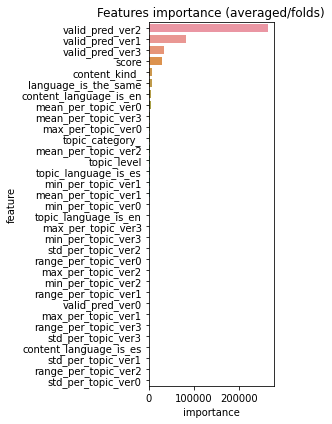

In [ ]:
model.show_feature_importance()

In [ ]:
feature_importance_df

,feature,importance,fold
0,topic_level,3701.739098,0
1,score,21985.517858,0
2,valid_pred_ver0,1608.168462,0
3,valid_pred_ver1,22808.392621,0
4,valid_pred_ver2,100521.181571,0
...,...,...,...
28,topic_language_is_en,1071.597408,4
29,topic_language_is_es,3589.780403,4
30,content_language_is_en,8261.096500,4
31,content_language_is_es,1052.259071,4


In [ ]:
oof_df["pred"]

0         0.882316
1         0.021314
2         0.024160
3         0.012249
4         0.008331
            ...   
359495    0.144895
359496    0.013970
359497    0.005122
359498    0.019834
359499    0.090344
Name: pred, Length: 359500, dtype: float64

In [ ]:
for top in range(1, 20, 1):
    best_score, best_threshold = get_f2_score(oof_df["pred"].values, oof_df, TOP=top, apply_sigmoid=False)
    print(top, best_score, best_threshold)

Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

1 0.6025058606685629 0.1


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

2 0.5998033536252309 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

3 0.6002545576223602 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

4 0.6004906966033685 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

5 0.6004570362080703 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

6 0.6005149527160866 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

7 0.6004987012973159 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

8 0.6008124116851565 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

9 0.6007647947433806 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

10 0.6007807496828476 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

11 0.6009759768329782 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

12 0.6008977723495736 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

13 0.6009750683924194 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

14 0.6020117816532312 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

15 0.6019574764264893 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

16 0.6018943514673349 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

17 0.6018052849003431 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

18 0.6017572276154092 0.001


Search best threshold:   0%|          | 0/499 [00:00<?, ?it/s]

19 0.6017241132105916 0.001


0.6035 14 0.001

In [ ]:
len(CFG.use_features)

33

In [ ]:
df["fold"].value_counts()

0.0    181150
3.0     44800
4.0     44600
2.0     44600
1.0     44350
Name: fold, dtype: int64

In [ ]:
oof_df.groupby("target")["pred"].value_counts()

target  pred
0       0       312846
        1        19717
1       1        20633
        0         6304
Name: pred, dtype: int64

In [ ]:
df

,topic_id,predictions,target,topic_language,topic_channel,topic_category,topic_level,score,content_language,content_kind,...,max_per_topic_ver3,std_per_topic_ver3,range_per_topic_ver3,topic_category_,content_kind_,topic_language_is_en,topic_language_is_es,content_language_is_en,content_language_is_es,language_is_the_same
0,t_0012a45fa09c,c_dde078b8ea7a,1,en,2ee29d,aligned,4,0.743472,en,exercise,...,8.593512,2.657373,19.059960,0,2,1,0,1,0,1
1,t_0012a45fa09c,c_139907ad9cf0,0,en,2ee29d,aligned,4,0.669632,en,video,...,8.593512,2.657373,19.059960,0,1,1,0,1,0,1
2,t_0012a45fa09c,c_05a5aed8ccec,0,en,2ee29d,aligned,4,0.613423,en,document,...,8.593512,2.657373,19.059960,0,0,1,0,1,0,1
3,t_0012a45fa09c,c_26fd56fd6382,0,en,2ee29d,aligned,4,0.597120,en,video,...,8.593512,2.657373,19.059960,0,1,1,0,1,0,1
4,t_0012a45fa09c,c_92153d6a566d,0,en,2ee29d,aligned,4,0.595151,en,exercise,...,8.593512,2.657373,19.059960,0,2,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359495,t_fff9e5407d13,c_026db653a269,1,es,71fd51,supplemental,2,0.551677,es,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,1,1
359496,t_fff9e5407d13,c_b894de7e8725,0,es,71fd51,supplemental,2,0.551287,pt,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,0,0
359497,t_fff9e5407d13,c_f7e15fcee474,0,es,71fd51,supplemental,2,0.550654,pt,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,0,0
359498,t_fff9e5407d13,c_4fee67386c4a,0,es,71fd51,supplemental,2,0.550607,es,html5,...,9.236372,6.115587,19.650229,1,4,0,1,0,1,1
